In [62]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# START

In [63]:
import sys
sys.path.insert(0, r'../../../quetzal')
from quetzal.model import stepmodel
import pandas as pd

In [64]:
training_folder = '../../'
plot_path = training_folder + 'outputs/plot/'

In [65]:
road = stepmodel.read_zippedpickles(training_folder + r'model/{scen}/aon_pathfinder'.format(scen=scenario))
distribution = stepmodel.read_zippedpickles(training_folder + r'model/{scen}/distribution'.format(scen=scenario))
sm = road.copy()
sm.volumes = distribution.volumes

volumes: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 374.97it/s]


In [66]:
# each link can have its own capacity
sm.road_links['capacity'] = 2000

# 'volume_car' is used for road pathfinder
sm.volumes['volume_car'] = sm.volumes['car_owner']
sm.road_links
constrained = sm.copy()
free = sm.copy()

In [67]:
v = sm.volumes.set_index(['origin', 'destination'])["car_owner"]
#on suppprime les OD avec peut de trajets potentiels
od_set = set(v.loc[v>1].index)

In [68]:
constrained.step_road_pathfinder(method='BFW',
                             tolerance=0.01,
                             maxiters=50,
                             od_set=od_set,
                             volume_column="volume_car",
                             log=True,
                             num_cores=4,
                             access_time='time')

vdf not found in road_links columns. Values set to 'default_bpr'
alpha not found in road_links columns. Values set to 0.15
beta not found in road_links columns. Values set to 4
limit not found in road_links columns. Values set to 20
penalty not found in road_links columns. Values set to 0
iteration | Phi |  Rel Gap (%)
0 0.1609 35.464
1 0.15 16.976
2 0.1422 7.51
3 0.1438 3.415
4 0.2 1.712
5 0.5063 0.894
6 0.8 0.455
7 0.8 0.099
8 0.8 0.014
9 0.1391 0.483
10 0.5063 0.049
11 0.4734 0.052
12 0.8 0.087
13 0.8 0.013
14 0.8 0.004


In [69]:
free.step_road_pathfinder(method='aon', od_set=od_set)

In [70]:
constrained.to_zippedpickles(training_folder + 'model/{scen}/constrained_road_pathfinder'.format(scen=scenario))

relgap: 100%|██████████████████████████████████████████████████████████████████████████| 33/33 [00:04<00:00,  6.88it/s]


# PLOT

KeyError: 'flow'

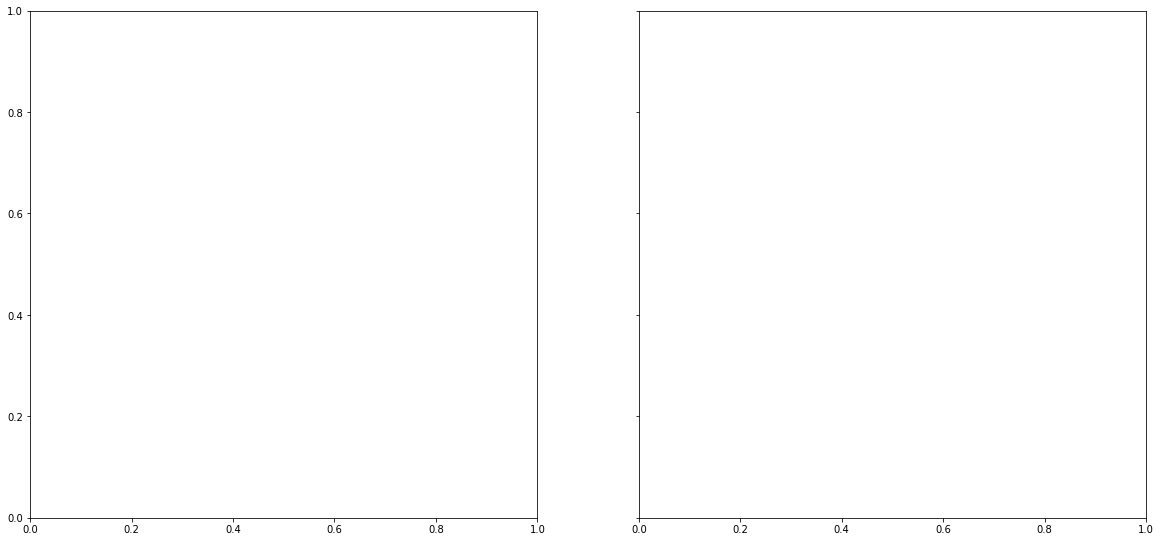

In [10]:
if manual:
    import matplotlib.pyplot as plt
    %matplotlib inline
    fig, axes = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=[20, 20])

    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')

    from syspy.syspy_utils import data_visualization as dv
    bandwidth = dv.bandwidth
    power=0.5
    lv = [100, 1000, 2000, 5000, 7000]

    url = 'http://a.basemaps.cartocdn.com/dark_nolabels/tileZ/tileX/tileY.png'
    plot = bandwidth(
        free.road_links.loc[free.road_links['flow'] > 0], value='flow',
        power=0.5, figsize=[25, 15], scale=0.5, legend_values=lv, 
        label_kwargs={'color':'white', 'fontsize':16}, ax=axes[0]
    )
    dv.add_basemap(plot, url=url, zoom=12)
    plot.set_title("Free assignment")

    plot = bandwidth(
        constrained.road_links.loc[constrained.road_links['flow'] > 0], value='flow',
        power=0.5, figsize=[25, 15], scale=0.5, legend_values=lv, 
        label_kwargs={'color':'white', 'fontsize':16}, ax=axes[1]
    )
    dv.add_basemap(plot, url=url, zoom=12)
    plot.set_title("Constrained assignment")
    fig.tigh_layout=True

In [ ]:
if manual:
    c = constrained.car_los.groupby(['origin', 'destination'])['actual_time'].min()
    f = free.car_los.groupby(['origin', 'destination'])['actual_time'].min()
    df = pd.DataFrame([c, f], index=['constrained', 'free']).T
    df.plot(kind='scatter', y='constrained', x='free', figsize=[10, 10], s=1)